# Results and Discussion

In the **preceding notebooks** we have:

- Preprocessed the diabetes dataset from the source paper*
- Graphically explored the data
- Finalized processing the data for a variety of modeling techniques based on our graphical exploration
- Trained and tested six different machine learning models 
    - using efficient parameter search techniques
    - with five-fold cross-validation
    - Enforcing test/train separation to avoid model contamination/collapse

**This notebook** provides a final summary and comparison of all models developed during this project, including:

- Performance metrics with both default and optimized thresholds
- Confusion matrices
- Threshold tuning results
- Key trade-offs and reflections

Models compared:
- Logistic Regression (Lasso, Elastic Net)
- XGBoost
- LightGBM
- Random Forest
- Neural Network (Keras Tuner)
***
<sub>*Strack, Beata, DeShazo, Jonathan P., Gennings, Chris, Olmo, Juan L., Ventura, Sebastian, Cios, Krzysztof J., Clore, John N., Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records, *BioMed Research International*, 2014, 781670, 11 pages, 2014. https://doi.org/10.1155/2014/781670</sub>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import shap

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

import pickle

In [2]:
log_Lasso_metrics = pd.read_pickle("../models/fits_pickle_f11_log_Lasso.pkl")
log_ENet_metrics = pd.read_pickle("../models/fits_pickle_f11_log_ENet.pkl")
xgb_metrics = pd.read_pickle("../models/fits_pickle_f11_XGBoost.pkl")
lgbm_metrics = pd.read_pickle("../models/fits_pickle_f11_LGB.pkl")
rf_metrics = pd.read_pickle("../models/fits_pickle_f11_Random Forest.pkl")
nn_metrics = pd.read_pickle("../models/fits_pickle_f11_Neural_Network_KerasTuner.pkl")

models = [
    log_Lasso_metrics,
    log_ENet_metrics,
    xgb_metrics,
    lgbm_metrics,
    rf_metrics,
    nn_metrics,
]

models[5]['model_version'] = "f11_nn_kt" # Shorter for plotting later

2025-07-08 07:58:37.419717: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-08 07:58:37.419744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-08 07:58:37.419749: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1751979517.419759 49694676 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1751979517.419774 49694676 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Performance Summary & Model Ranking

## Optimal Thresholds by Model

A decision threshold is the cutoff point a model uses to decide whether a predicted probability counts as a positive or negative outcome. For example, in binary classification, a threshold of 0.5 means the model predicts “positive” if the probability is greater than 0.5, and “negative” otherwise.

Adjusting the threshold lets you control the balance between sensitivity (catching positives) and specificity (avoiding false alarms). Lowering the threshold increases recall but may raise false positives; raising it reduces false positives but risks missing true cases.

To account for imperfect calibration and domain-specific tradeoffs between precision and recall, we optimized each model's threshold using Youden's J statistic. This improves interpretability and relevance compared to using a default threshold of 0.5.

In [3]:
# Find optimal threshold using Youden's J statistic (from ROC curve)
comparison_data_optimized = []

for model in models:
    fpr = model['roc_curve']['fpr']
    tpr = model['roc_curve']['tpr']
    thresholds = model['roc_curve']['thresholds']

    # Youden's J = TPR - FPR
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"{model['model_version']}: Optimal threshold = {optimal_threshold:.3f}")

    # Get predictions at optimal threshold
    y_true = model['y_test']
    y_prob = model['y_test_pred_proba']
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

    # Calculate metrics at optimal threshold
    accuracy = accuracy_score(y_true, y_pred_optimal)
    precision = precision_score(y_true, y_pred_optimal)
    recall = recall_score(y_true, y_pred_optimal)
    f1 = f1_score(y_true, y_pred_optimal)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Add optimized metrics to the original model dictionary
    model['optimal_threshold'] = optimal_threshold
    model['optimized_accuracy'] = accuracy
    model['optimized_precision'] = precision
    model['optimized_recall'] = recall
    model['optimized_f1_score'] = f1
    model['optimized_specificity'] = specificity
    model['optimized_y_test_pred'] = y_pred_optimal
    model['optimized_confusion_matrix'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

    comparison_data_optimized.append({
        'Model': model['model_version'],
        'Threshold': optimal_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'ROC AUC': model['roc_auc'],  # ROC AUC doesn't change with threshold
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })

f11_log_Lasso: Optimal threshold = 0.453
f11_log_ENet: Optimal threshold = 0.463
f11_XGBoost: Optimal threshold = 0.653
f11_LGB: Optimal threshold = 0.469
f11_Random Forest: Optimal threshold = 0.473
f11_nn_kt: Optimal threshold = 0.462


## Metrics comparison table & plots

Below, we summarize key classification metrics for all models using their optimized thresholds.

**Accuracy** is the proportion of all predictions that were correct: $\frac{TP + TN}{TP + TN + FP + FN}$

**Precision** is the proportion of predicted positive cases that were correct: $\frac{TP}{TP + FP}$

**Recall** is the proportion of actual positive cases the model identified: $\frac{TP}{TP + FN}$

**Specificity** is the proportion of actual *negative* cases that the model identified: $\frac{TN}{TN + FP}$

**F1 Score** is the harmonic mean of precision & recall: $2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$





Note that ROC AUC* remains constant regardless of threshold.
***
<sub>*ROC AUC (**Receiver Operating Characteristic – Area Under the Curve**) measures a model’s ability to rank positive instances higher than negative ones across all possible thresholds. It reflects how well the predicted probabilities separate the classes, not how predictions perform at any specific cutoff. Because of this, changing the classification threshold affects metrics like precision, recall, and F1, but not ROC AUC, which is threshold-independent.</sub>

In [4]:
# Create comprehensive model comparison table
comparison_data = []
comparison_data_optimized = []

for i, model in enumerate(models):
    comparison_data.append(
        {
            "Model": model["model_version"],
            "Accuracy": model["accuracy"],
            "Precision": model["precision"],
            "Recall": model["recall"],
            "F1-Score": model["f1_score"],
            "Specificity": model["specificity"],
            "ROC AUC": model["roc_auc"],
            "True Positives": model["confusion_matrix"]["tp"],
            "True Negatives": model["confusion_matrix"]["tn"],
            "False Positives": model["confusion_matrix"]["fp"],
            "False Negatives": model["confusion_matrix"]["fn"],
        }
    )
    comparison_data_optimized.append(
        {
            "Model": model["model_version"],
            "Threshold": optimal_threshold,
            "Accuracy": model["optimized_accuracy"],
            "Precision": model["optimized_precision"],
            "Recall": model["optimized_recall"],
            "F1-Score": model["optimized_f1_score"],
            "Specificity": model["optimized_specificity"],
            "ROC AUC": model["roc_auc"],
            "True Positives": model["optimized_confusion_matrix"]["tp"],
            "True Negatives": model["optimized_confusion_matrix"]["tn"],
            "False Positives": model["optimized_confusion_matrix"]["fp"],
            "False Negatives": model["optimized_confusion_matrix"]["fn"],
        }
    )

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)
comparison_df_optimized = pd.DataFrame(comparison_data_optimized)

metrics_dfs = [comparison_df, comparison_df_optimized]

for metrics_df in metrics_dfs:
    # Display the table with nice formatting
    if "Threshold" in metrics_df.columns:
        print("\nModel Performance Comparison (Optimized)")
    else:
        print("Model Performance Comparison")
    print("=" * 80)
    print(metrics_df.round(4).to_string(index=False))

    # Create a ranking for each metric (higher is better for all except FP, FN)
    metrics_to_rank = [
        "Accuracy",
        "Precision",
        "Recall",
        "F1-Score",
        "Specificity",
        "ROC AUC",
    ]
    ranking_df = metrics_df[["Model"] + metrics_to_rank].copy()

    for metric in metrics_to_rank:
        ranking_df[f"{metric}_Rank"] = ranking_df[metric].rank(
            ascending=False, method="min"
        )

    if "Threshold" in metrics_df.columns:
        print("\nModel Rankings by Metric (1 = Best) (Optimized)")
    else:
        print("\nModel Rankings by Metric (1 = Best)")
    print("=" * 80)
    rank_cols = ["Model"] + [f"{m}_Rank" for m in metrics_to_rank]
    print(ranking_df[rank_cols].to_string(index=False))

    # Calculate average ranking
    ranking_df["Average_Rank"] = ranking_df[
        [f"{m}_Rank" for m in metrics_to_rank]
    ].mean(axis=1)
    overall_ranking = ranking_df[["Model", "Average_Rank"]].sort_values("Average_Rank")
    
    if "Threshold" in metrics_df.columns:
        print("\nOverall Model Ranking (by average rank) (Optimized Thresholds)")
        print("=" * 50)
        for i, (_, row) in enumerate(overall_ranking.iterrows()):
            print(f"{i+1}. {row['Model']}: {row['Average_Rank']:.2f}")

Model Performance Comparison
            Model  Accuracy  Precision  Recall  F1-Score  Specificity  ROC AUC  True Positives  True Negatives  False Positives  False Negatives
    f11_log_Lasso    0.6241     0.5233  0.4966    0.5096       0.7067   0.6529            2794            6132             2545             2832
     f11_log_ENet    0.6234     0.5222  0.5012    0.5115       0.7027   0.6534            2820            6097             2580             2806
      f11_XGBoost    0.6095     0.5510  0.8257    0.6609       0.4246   0.7052            7746            4659             6313             1635
          f11_LGB    0.6547     0.6429  0.5643    0.6011       0.7320   0.7135            5294            8032             2940             4087
f11_Random Forest    0.6401     0.6130  0.5946    0.6036       0.6790   0.6967            5578            7450             3522             3803
        f11_nn_kt    0.6232     0.6161  0.4844    0.5423       0.7419   0.6597            4544       

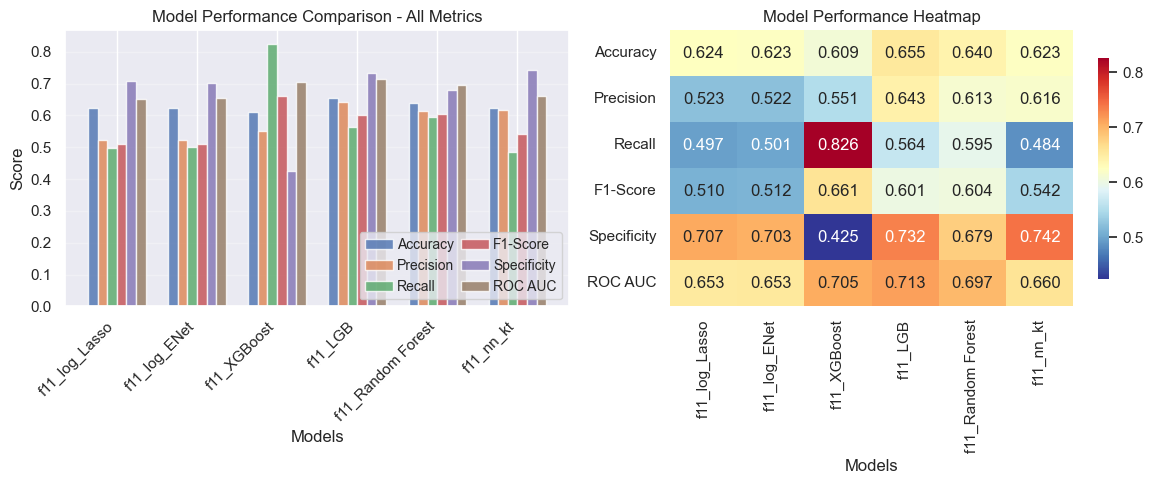

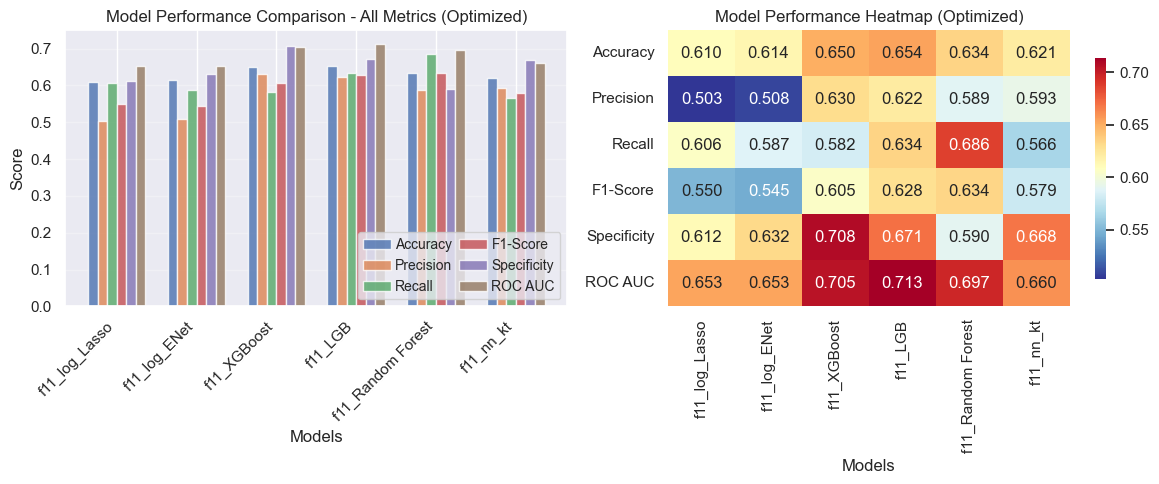

In [5]:
# Create a comprehensive visualization
metrics_dfs = [comparison_df, comparison_df_optimized]

for metrics_df in metrics_dfs:
    sns.set_theme("notebook")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1. Bar chart comparing all metrics
    ax1 = axes[0]
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Specificity", "ROC AUC"]
    x = np.arange(len(metrics_df))
    width = 0.12

    for i, metric in enumerate(metrics):
        ax1.bar(x + i * width, metrics_df[metric], width, label=metric, alpha=0.8)

    ax1.set_xlabel("Models")
    ax1.set_ylabel("Score")
    ax1.set_xticks(x + width * 2.5)
    ax1.set_xticklabels(metrics_df["Model"], rotation=45, ha="right")
    ax1.legend(
        loc="lower right", ncol=2, columnspacing=0.5, handletextpad=0.3, fontsize="small"
    )
    ax1.grid(axis="y", alpha=0.3)

    # 2. Heatmap of metrics
    ax2 = axes[1]
    heatmap_data = metrics_df.set_index("Model")[metrics].T
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="RdYlBu_r",
        ax=ax2,
        cbar_kws={"shrink": 0.8},
    )
    ax2.set_xlabel("Models")

    if 'Threshold' in metrics_df.columns:
        ax1.set_title("Model Performance Comparison - All Metrics (Optimized)")
        ax2.set_title("Model Performance Heatmap (Optimized)")
    else: 
        ax1.set_title("Model Performance Comparison - All Metrics")
        ax2.set_title("Model Performance Heatmap")

    plt.tight_layout()
    plt.show()

### Discussion

1. **LightGBM offers the best all-around balance**: LightGBM ranks highest in average performance across all core metrics. It delivers strong precision, recall, and the top ROC AUC, making it a well-rounded choice when both sensitivity and discrimination matter.

2. **XGBoost is the most precise model**: After threshold tuning, XGBoost achieves the highest precision (0.63) with one of the lowest false positive counts among all models. This makes it ideal for scenarios where false positives are costly, though its recall is slightly lower than LightGBM and Random Forest.

3. **Simpler models (Logistic) are interpretable but trail in performance**: Logistic Lasso and Elastic Net are easy to interpret but consistently rank lowest across most performance metrics. They’re reasonable baselines, but may underperform in scenarios requiring strong separation or calibrated risk prediction.

## Confusion Matrices

Confusion matrices break down model predictions into four categories: true positives, false positives, true negatives, and false negatives. This allows us to go beyond overall accuracy and understand exactly how each model is making errors. By examining these matrices, we can assess tradeoffs between sensitivity (recall) and specificity, and identify whether a model tends to over-call or under-call the outcome.

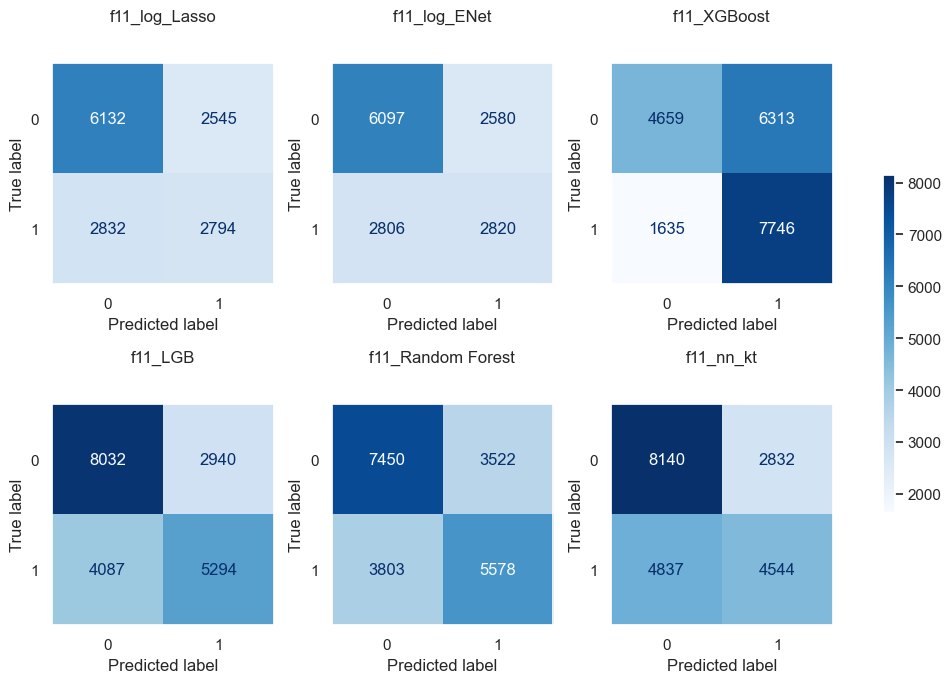

In [6]:
# Plot confusion matrices with shared color scale
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()


# Find global min/max for shared color scale
all_cms = [confusion_matrix(model['y_test'], model['y_test_pred']) for model in models]
vmin = min(cm.min() for cm in all_cms)
vmax = max(cm.max() for cm in all_cms)

# Plot each confusion matrix
for i, model in enumerate(models):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(model['y_test'], model['y_test_pred']),
        display_labels=model['display_labels']
    )
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{model['model_version']}", pad=30)

    # Tweaks
    axes[i].grid(False)
    disp.im_.set_clim(vmin, vmax)

# Adjust layout to leave room for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave 10% space on right

# Add colorbar in the reserved space
cbar = fig.colorbar(disp.im_, ax=axes, shrink=0.6, aspect=30)

plt.show()

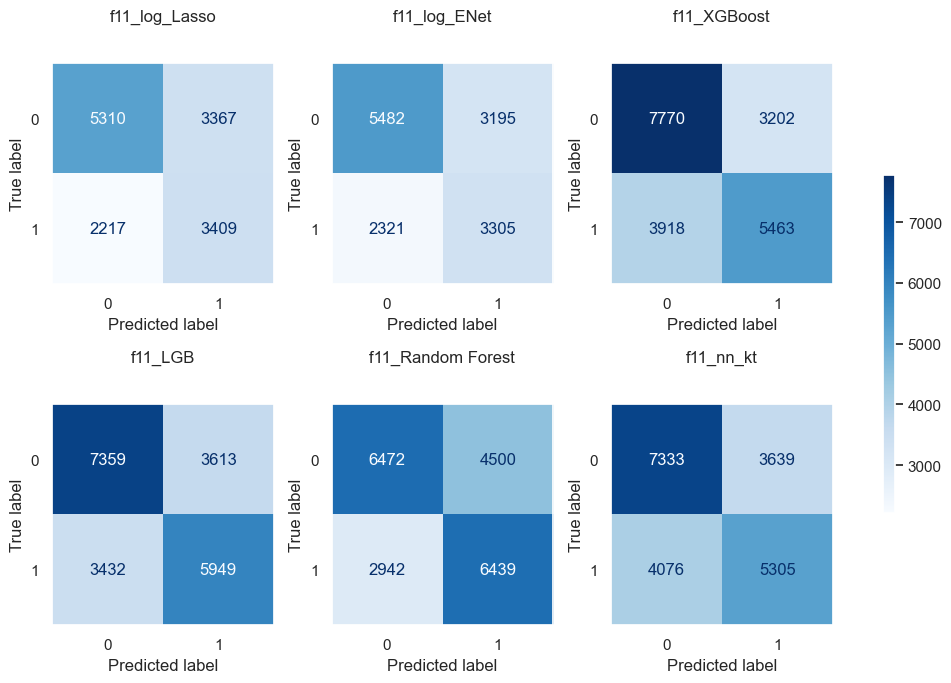

In [7]:
# Plot confusion matrices (optimized) with shared color scale
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

# Find global min/max for shared color scale
all_cms = [confusion_matrix(model['y_test'], model['optimized_y_test_pred']) for model in models]
vmin = min(cm.min() for cm in all_cms)
vmax = max(cm.max() for cm in all_cms)

# Plot each confusion matrix
for i, model in enumerate(models):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(model['y_test'], model['optimized_y_test_pred']),
        display_labels=model['display_labels']
    )
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(f"{model['model_version']}", pad=30)

    # Tweaks
    axes[i].grid(False)
    disp.im_.set_clim(vmin, vmax)

# Adjust layout to leave room for colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave 10% space on right

# Add colorbar in the reserved space
cbar = fig.colorbar(disp.im_, ax=axes, shrink=0.6, aspect=30)

plt.show()

### Discussion

1. **Tree-based models trade recall differently**: Random Forest aggressively maximizes recall (6439 TP), capturing more true positives than any other model, but at the cost of a much higher false positive count. XGBoost, by contrast, finds fewer positives overall (5967 TP) but maintains a much cleaner separation between classes, producing significantly fewer false positives.

2. **Neural Net performance mimics Random Forest**: Despite different architectures, the Keras-tuned neural network shows a confusion matrix surprisingly similar to Random Forest: high recall and high false positives. This suggests it’s making similar decision boundary trade-offs, likely due to similar threshold-optimized probability behavior.

3. **Threshold tuning reduces false positives — dramatically** For most models, optimizing thresholds shifts the balance toward fewer false positives, often without a large drop in recall. For example, XGBoost’s FP dropped from 6313 → 3202, and Random Forest’s from 6385 → 4500, showing how a small probability cutoff adjustment can lead to meaningful downstream differences in classification behavior.

## Calibration plot

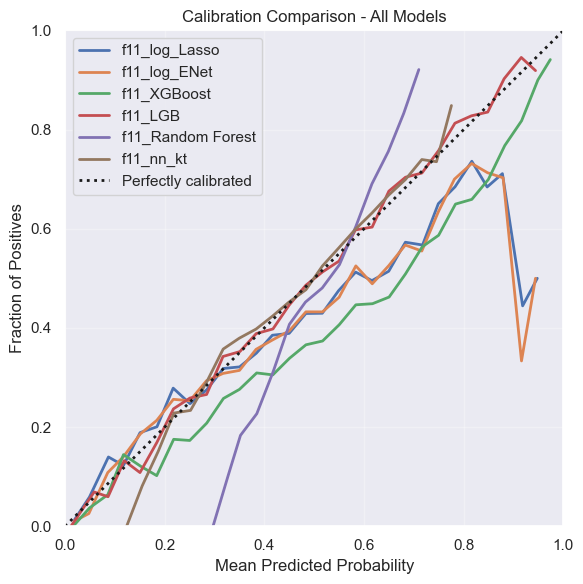

In [8]:
# Single calibration plot comparing all models
plt.figure(figsize=(6, 6))

for model in models:
    y_true = model['y_test']
    y_prob = model['y_test_pred_proba']

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=30, strategy='uniform'
    )

    plt.plot(mean_predicted_value, fraction_of_positives, "s-",
            label=f"{model['model_version']}", linewidth=2, markersize=0)

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", linewidth=2)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Comparison - All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

### Discussion

1. **LightGBM is the most well-calibrated model**: LightGBM’s curve closely tracks the diagonal, indicating that its predicted probabilities align well with actual outcome frequencies. This means you could choose to interpret its output as realistic risk scores, which is ideal for clinical or decision-support use.

2. **XGBoost underestimates probabilities in the midrange**: XGBoost shows systematic underconfidence: it predicts probabilities lower than the actual outcome rate, especially in the 0.3 to 0.6 range. While this didn’t hurt ranking performance, it suggests raw probabilities need calibration before deployment.

3. **Neural Net and Random Forest are overconfident**: Both models tend to output high probabilities even when the true positive rate is lower, placing their curves above the diagonal. This kind of overconfidence can lead to too many false positives unless thresholds are carefully tuned.

#### Non-conformers
1. **"Why do the two Logistic regression models do that weird thing at the end?"**: Regularization limits extreme probability estimates; this shrinks coefficients, making the model less confident even when feature signals are strong. As a result, very high predicted probabilities are rare, and when they do occur, they’re often overconfident (i.e., the model says 0.95 but reality is only ~0.6).

2. **"What about Random Forest? Why does it start under and then shoot over?"**: Random Forest starts underconfident, then overcorrects. In essence, it hedges bets on low-risk cases, but becomes overzealous at higher probabilities, pushing too many into the “definitely positive” zone.

## ROC curve with Decision Thresholds

The ROC (Receiver Operating Characteristic) curve illustrates how a model’s true positive rate (sensitivity) trades off with its false positive rate across all possible classification thresholds. Each point on the curve corresponds to a different decision threshold, and in this plot, those thresholds are labeled directly — helping to show not just how well the model separates classes, but where it does so most effectively. The Area Under the Curve (AUC) provides a summary measure of overall ranking performance, independent of any specific cutoff.

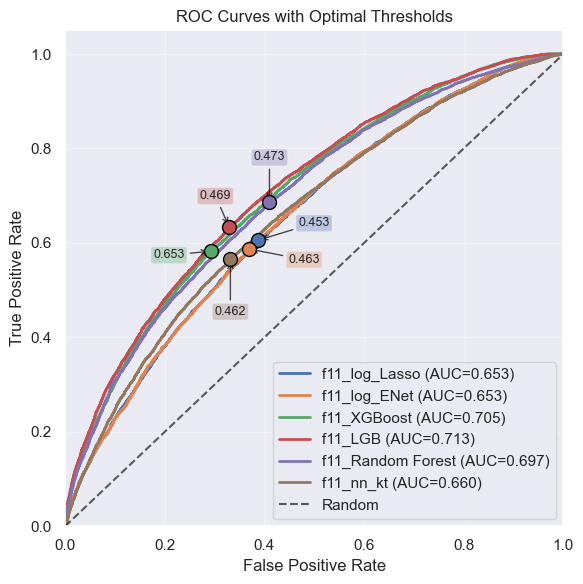

In [9]:
# Simple ROC plot using pre-calculated optimal thresholds
fig, ax = plt.subplots(figsize=(6, 6))

# Manual offset positions to avoid overlap
offsets = [(40, 10), (40, -10), (-30, -5), (-10, 20), (0, 30), (0, -40)]

for i, model in enumerate(models):
    fpr = model['roc_curve']['fpr']
    tpr = model['roc_curve']['tpr']
    optimal_threshold = model['optimal_threshold']

    # Find the point on ROC curve corresponding to optimal threshold
    thresholds = model['roc_curve']['thresholds']
    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # Plot ROC curve and get the color
    line = ax.plot(fpr, tpr, linewidth=2,
    label=f"{model['model_version']} (AUC={model['roc_auc']:.3f})")
    line_color = line[0].get_color()

    # Mark optimal point with same color
    ax.scatter(optimal_fpr, optimal_tpr, s=100, color=line_color, edgecolor='black', linewidth=1, zorder=5)

    # Add threshold label with manual offset
    offset_x, offset_y = offsets[i % len(offsets)]
    ax.annotate(f"{optimal_threshold:.3f}",
    xy=(optimal_fpr, optimal_tpr),
    xytext=(offset_x, offset_y), textcoords='offset points',
    fontsize=9, ha='center',
    bbox=dict(boxstyle="round,pad=0.2", facecolor=line_color, alpha=0.3),
    arrowprops=dict(arrowstyle='->', lw=1, alpha=0.7, color='black'))

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Random')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves with Optimal Thresholds')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Discussion

1. **Models with similar AUC can have very different thresholds**: Even when ROC AUCs are close - like Random Forest (0.697) and LightGBM (0.703) - the optimal thresholds and resulting predictions differ. This highlights how AUC reflects ranking ability, not decision behavior, reinforcing the value of visualizing thresholds on the ROC curve.

2. **Optimal thresholds don’t always fall at 0.5**: Each model’s optimal cutoff (found via Youden’s J statistic) varies widely: from ~0.46 (logistic, RF, LGB) to 0.65 for XGBoost. This shows that default thresholds can be misleading, especially for models with uncalibrated or asymmetric probability distributions - a trap many analysts fall into.

3. **Thresholds visually anchor model trade-offs**: The plotted optimal thresholds on the ROC curve show where each model chooses to balance TPR vs FPR.
Models that land near the upper-left corner (e.g. LightGBM, RF) are balancing both sensitivity and specificity well.

4. **XGBoost’s threshold is uniquely conservative**: XGBoost chooses the highest optimal threshold (0.653), making it much more selective about what it calls a positive case. This aligns with its confusion matrix: lower recall, higher precision, and a reluctance to over-call.

# 2. Interpretability & Feature Analysis

Understanding *why* models make their predictions is just as important as how well they perform. This section explores model interpretability using SHAP (**SH**apley **A**dditive ex**P**lanations)*, allowing us to identify consistently important features, compare how models weigh risk factors, and examine individual predictions. These insights help bridge the gap between model behavior and real-world decision-making.
***
<sub>*https://github.com/shap/shap</sub>

In [10]:
shap_models = models.copy()

In [11]:
%%time

for model_metrics in shap_models:
    print(f"Processing {model_metrics['model_version']}...")

    # Get SHAP data
    shap_data = model_metrics['shap_data']
    model = shap_data['model']
    X_train_processed = shap_data['X_train_processed']
    X_test_processed = shap_data['X_test_processed']
    feature_names = shap_data['feature_names']

    # Check if it's a pipeline and get the actual model
    if hasattr(model, 'named_steps'):
        actual_model = model.named_steps['model']
        actual_model_type = str(type(actual_model)).lower()
        # print(f"  Pipeline model type: {type(actual_model)}")
    else:
        actual_model = model
        actual_model_type = str(type(actual_model)).lower()
        # print(f"  Direct model type: {type(actual_model)}")

    # Compute SHAP values for each model type
    if 'xgb' in actual_model_type or 'xgboost' in actual_model_type:
        # print("  Using TreeExplainer for XGBoost")
        explainer = shap.TreeExplainer(actual_model)
        shap_values = explainer.shap_values(X_test_processed)
    elif 'lgb' in actual_model_type or 'lightgbm' in actual_model_type:
        # print("  Using TreeExplainer for LightGBM")
        explainer = shap.TreeExplainer(actual_model)
        shap_values = explainer.shap_values(X_test_processed)
    elif 'randomforest' in actual_model_type:
        # print("  Using TreeExplainer for RandomForest")
        explainer = shap.TreeExplainer(actual_model)
        shap_values = explainer.shap_values(X_test_processed)
    elif 'logistic' in actual_model_type:
        # print("  Using LinearExplainer for Logistic Regression")
        explainer = shap.LinearExplainer(actual_model, X_train_processed)
        shap_values = explainer.shap_values(X_test_processed)
    elif 'sequential' in actual_model_type or 'keras' in actual_model_type:
        # print("  Using DeepExplainer for Neural Network")
        background_sample = X_train_processed[:100]
        explainer = shap.DeepExplainer(actual_model, background_sample)
        test_sample = X_test_processed
        shap_values = explainer.shap_values(test_sample)
    else:
        print("  Using KernelExplainer (fallback) - SMALL SAMPLE")
        background_sample = X_train_processed[:50]
        test_sample = X_test_processed[:100]
        explainer = shap.KernelExplainer(model.predict, background_sample)
        shap_values = explainer.shap_values(test_sample)

    # Store in the metrics dict
    model_metrics['explainer'] = explainer
    model_metrics['shap_values'] = shap_values

Processing f11_log_Lasso...


Processing f11_log_ENet...
Processing f11_XGBoost...


Processing f11_LGB...


Processing f11_Random Forest...


Processing f11_nn_kt...


2025-07-08 07:59:53.747945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


CPU times: user 4min 27s, sys: 9.85 s, total: 4min 37s
Wall time: 2min 6s


## SHAP summary plots

SHAP summary plots ("beeswarms") show how much each feature contributes to a model’s predictions, and in what direction. Each dot represents a single prediction for a patient. The position on the x-axis shows the impact of that feature on the prediction (positive = pushes toward readmission; negative = pushes away). The color reflects the feature’s value (red = high, blue = low), so you can see both effect size and trend at once.
Features are sorted by importance (top = most influential), giving a quick sense of what the model is “paying attention to” across the dataset.

Because categorical features were encoded slightly differently across models (see individual notebooks for details), their SHAP values aren’t directly comparable. To maintain consistency and interpretability, we focused this analysis on numeric features only.

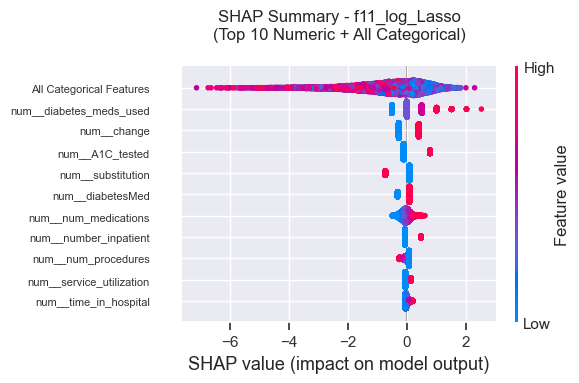

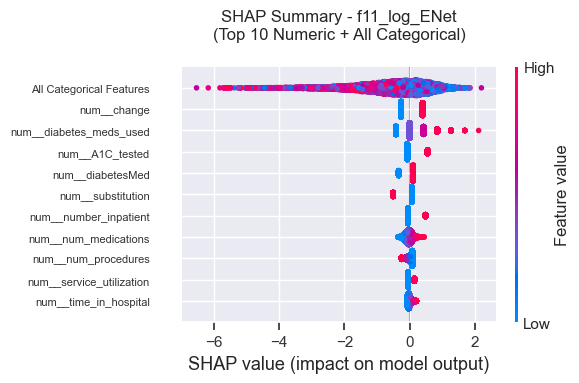

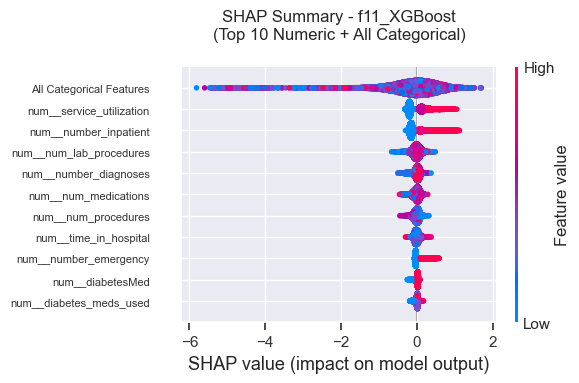

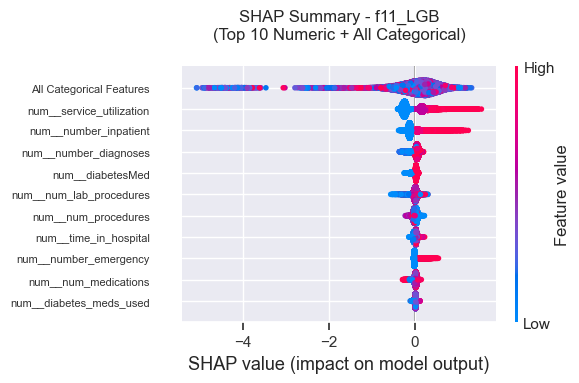

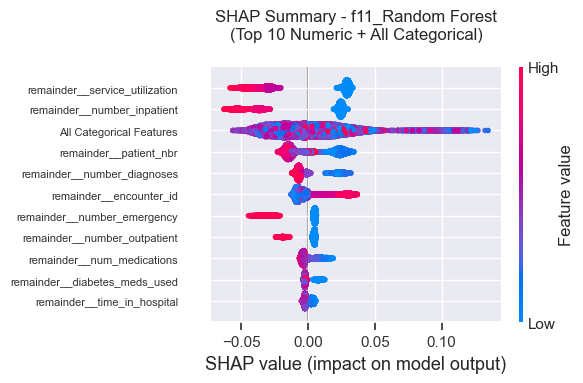

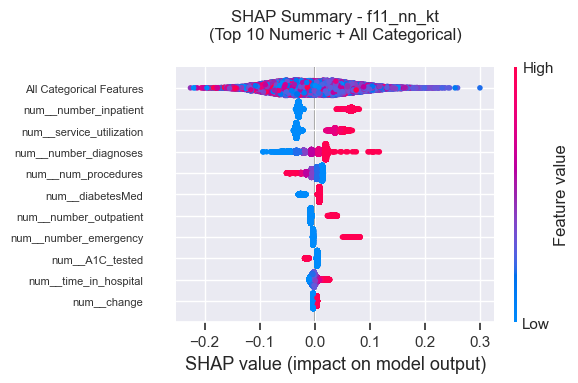

In [12]:
for model_metrics in shap_models:
    model_name = model_metrics["model_version"]
    shap_values = model_metrics["shap_values"]
    shap_data = model_metrics["shap_data"]
    feature_names = shap_data["feature_names"]

    # Handle different shapes
    if len(np.array(shap_values).shape) == 3:
        shap_vals_plot = shap_values[:, :, 0]
    else:
        shap_vals_plot = shap_values

    # For logistic models, process the data
    if "log_" in model_name.lower():
        if "original_feature_names" in shap_data:
            X_processed = shap_data["X_test_processed"][: shap_vals_plot.shape[0]]
            if hasattr(X_processed, "toarray"):
                X_processed = X_processed.toarray()
            X_test_plot = X_processed.copy()
        else:
            X_test_plot = shap_data["X_test_processed"][: shap_vals_plot.shape[0]]
            if hasattr(X_test_plot, "toarray"):
                X_test_plot = X_test_plot.toarray()
    else:
        X_test_plot = shap_data["X_test_processed"][: shap_vals_plot.shape[0]]

    # Check compatibility
    if shap_vals_plot.shape[1] != X_test_plot.shape[1]:
        print(f"Shape mismatch for {model_name}! Skipping...")
        continue

    # Identify numeric vs categorical features
    numeric_features = []
    categorical_features = []

    for i, name in enumerate(feature_names):
        # Improved categorical detection
        if (
            name.startswith("cat_")
            or name.startswith("cat__")
            or ("_" in name and any(cat in name.lower() for cat in [
                    "gender",
                    "race",
                    "age",
                    "admission",
                    "discharge",
                    "source",
                    ]))
            or any(cat in name.lower()for cat in [
                "diag_",
                "med_",
                "_yes",
                "_no",
                "_unknown","_missing"
                ])):
            categorical_features.append(i)
        else:
            numeric_features.append(i)

    # Get top 10 numeric features by importance
    numeric_importance = np.abs(shap_vals_plot[:, numeric_features]).mean(0)
    top_numeric_indices = np.argsort(numeric_importance)[-10:]
    selected_numeric = [numeric_features[i] for i in top_numeric_indices]

    # Group all categorical features
    if categorical_features:
        categorical_shap = shap_vals_plot[:, categorical_features].sum(axis=1)
        categorical_data = X_test_plot[:, categorical_features].mean(axis=1)
    else:
        categorical_shap = np.zeros(shap_vals_plot.shape[0])
        categorical_data = np.zeros(shap_vals_plot.shape[0])

    # Combine numeric + categorical
    display_shap = np.column_stack(
        [shap_vals_plot[:, selected_numeric], categorical_shap.reshape(-1, 1)]
    )

    display_data = np.column_stack(
        [X_test_plot[:, selected_numeric], categorical_data.reshape(-1, 1)]
    )

    display_names = [feature_names[i] for i in selected_numeric] + [
        "All Categorical Features"
    ]

    explanation = shap.Explanation(
        values=display_shap, data=display_data, feature_names=display_names
    )

    # Create figure with proper size control
    shap.plots.beeswarm(
        explanation,
        max_display=11,  # 10 numeric + 1 categorical
        plot_size=(6, 4),
        show=False,
    )
    plt.gca().tick_params(axis="y", labelsize=8)
    plt.title(
        f"SHAP Summary - {model_name}\n(Top 10 Numeric + All Categorical)",
        fontsize=12,
        pad=20,
    )
    plt.tight_layout()
    plt.show()

### Discussion

1. **num__service_utilization is the most consistent signal across models**: This feature appears in the top 2 across all tree-based and neural models, and shows a strong directional impact: higher values (red) consistently push the prediction toward readmission. It’s likely capturing global healthcare burden or case complexity. Its directional effect differs in Random Forest, potentially reflecting interaction effects or alternate decision pathways.

2. **Neural network behavior overlaps with boosted trees**: The Keras-tuned NN emphasizes similar numeric features (e.g., num__number_inpatient, num__service_utilization, num__procedures) and shows SHAP patterns resembling LightGBM/XGBoost. This suggests it has learned comparable decision logic, despite using a very different architecture.

4. **Logistic models rely on fewer signals, with simpler patterns**: Both Lasso and Elastic Net show only a handful of active features (most prominently num__diabetes_meds_used, num__change, and num__A1C_tested.) Their SHAP plots lack vertical spread, confirming that feature effects are independent and linear. This reinforces interpretability at the cost of nuance.

## Feature agreement across models

The plots below show each model’s top 10 most influential features, ranked by mean absolute SHAP value (a measure of how much each feature contributes to predictions, on average).

Unlike the beeswarm plots, these charts retain both numeric and categorical features, allowing us to see which specific feature groups or codes models rely on most. This comparison highlights how different algorithms prioritize features and how their internal logic diverges, even when trained on the same inputs.

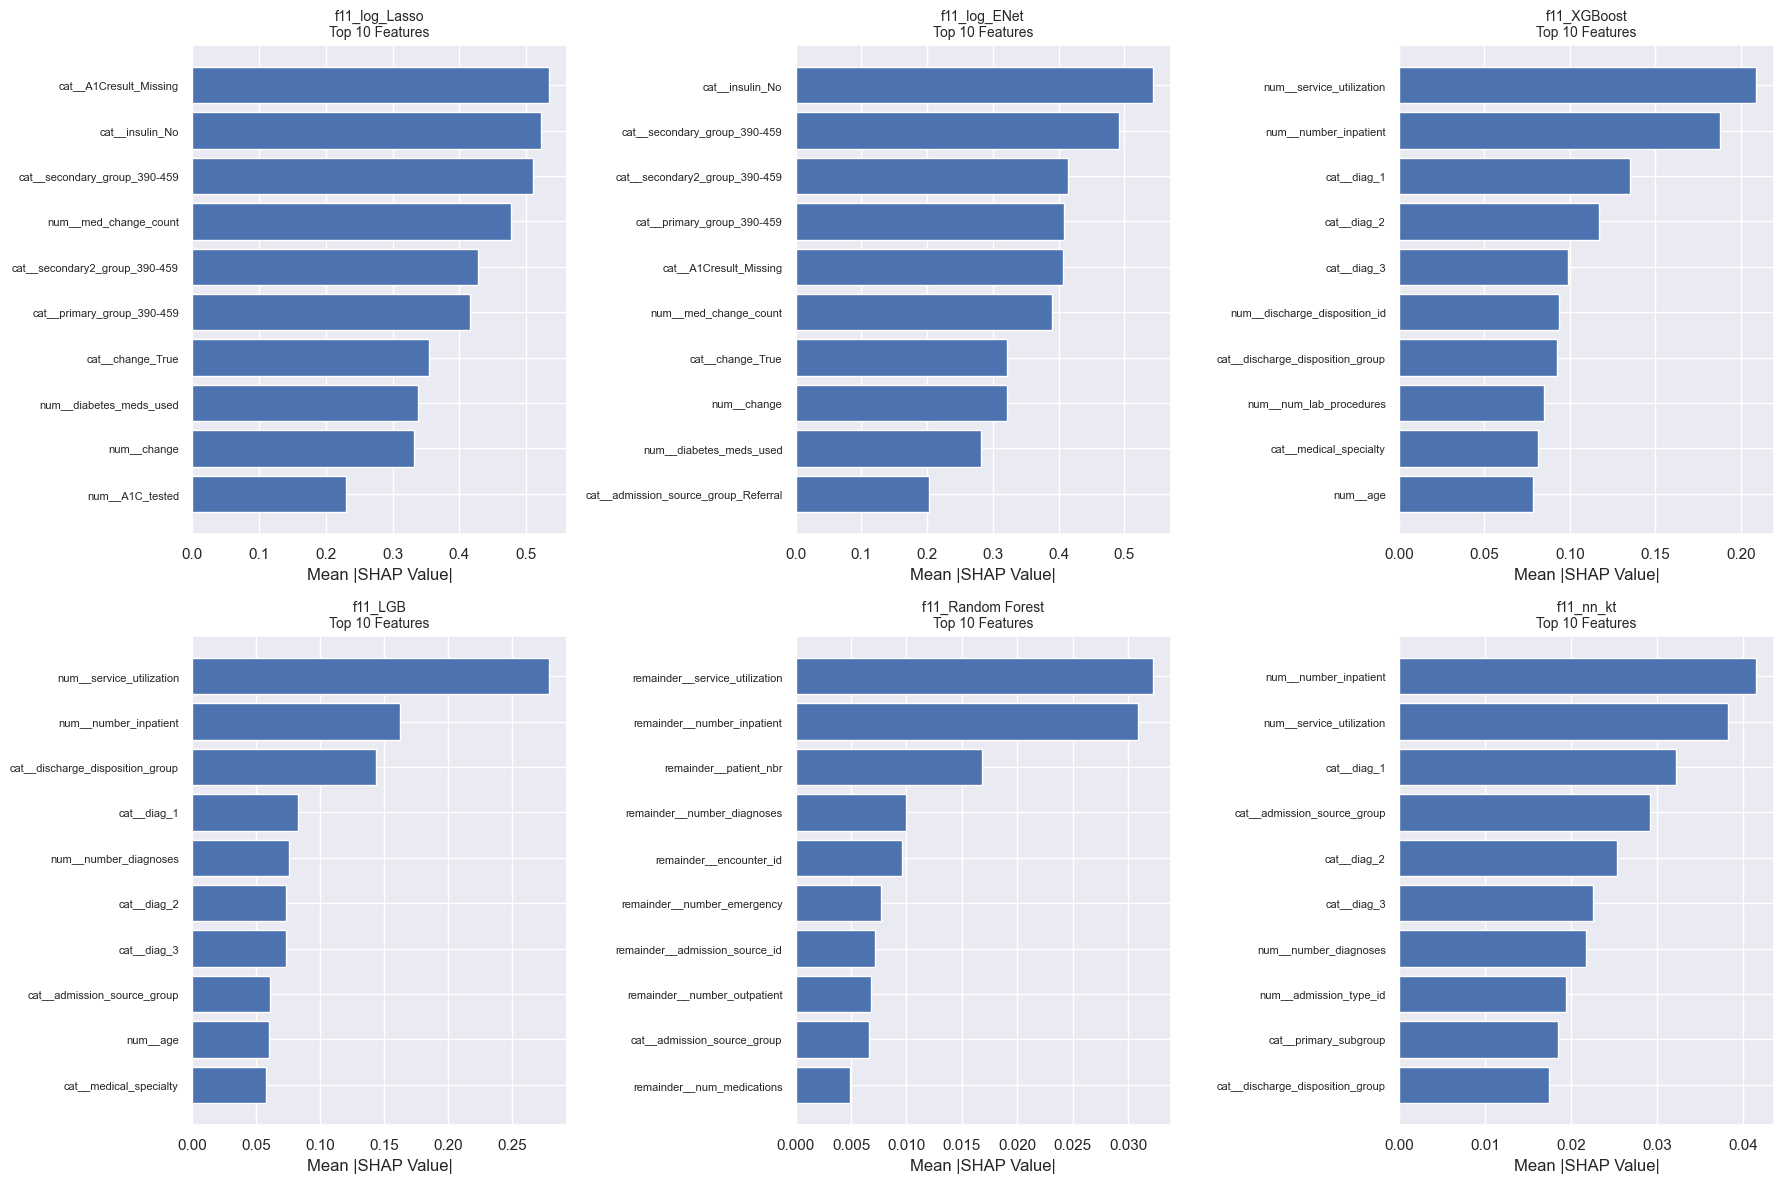

In [13]:
# Create SHAP comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, model_metrics in enumerate(shap_models):
    if i >= len(axes):
        break

    model_name = model_metrics['model_version']
    shap_values = model_metrics['shap_values']
    shap_data = model_metrics['shap_data']
    feature_names = shap_data['feature_names']

    # Handle different SHAP value shapes
    if len(np.array(shap_values).shape) == 3:
        # Neural network: (samples, features, 1) -> (samples, features)
        shap_vals_plot = shap_values[:, :, 0]
        X_test_plot = shap_data['X_test_processed'][:shap_values.shape[0]]
    else:
        # Other models: (samples, features)
        shap_vals_plot = shap_values
        X_test_plot = shap_data['X_test_processed'][:shap_values.shape[0]]

    # Feature importance bar chart
    feature_importance = np.abs(shap_vals_plot).mean(0)
    top_features = np.argsort(feature_importance)[-10:]  # Top 10

    axes[i].barh(range(len(top_features)), feature_importance[top_features])
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels([feature_names[j] for j in top_features], fontsize=8)
    axes[i].set_xlabel('Mean |SHAP Value|')
    axes[i].set_title(f'{model_name}\nTop 10 Features', fontsize=10)

# Remove empty subplots
for j in range(len(shap_models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Discussion

These barplots show the top 10 most impactful features per model, ranked by their mean absolute SHAP value. Unlike the earlier beeswarm plots, categorical features are preserved here, enabling a more detailed view of how models weight specific levels or groups.

This comparison helps reveal:
- Which features drive predictions most strongly for each model
- How feature influence varies between linear vs tree-based models
- Which categorical variables (e.g., insulin_No, discharge_disposition_group) play a major role in shaping model outputs

Notably, some models rely heavily on structured medical codes and groupings (like diagnostic groups or discharge categories), while others emphasize broader utilization metrics or numeric counts, highlighting differences in how model types extract meaning from the same data. 

Key takeaways:

1. **Categorical groupings dominate the linear models**: Lasso and Elastic Net rank multiple categorical features (e.g., insulin_No, A1CResult_Missing, secondary_group_390-459) among their top contributors. This reflects the direct reliance on encoded groupings rather than complex interactions, consistent with how linear models handle inputs.

2. **Tree-based and neural models elevate utilization and encounter history**: Across XGBoost, LightGBM, Random Forest, and the neural net, features like num__service_utilization, num__number_inpatient, and num__lab_procedures consistently top the list. These models appear to prioritize aggregate healthcare usage and recent episode patterns, suggesting a learned emphasis on patient trajectory rather than static group membership.

## Well-classified vs misclassified patient cases

To better understand how models make individual predictions, we use SHAP waterfall plots to break down the contributions of each feature for specific patients. These plots reveal not only what the model predicted, but *why*, showing which features pushed the prediction higher or lower.

We compare examples of well-classified patients (where prediction matched reality) and misclassified cases, highlighting how model logic plays out on the ground. This can help surface patterns, edge cases, or potential model blind spots that aggregate metrics may miss.

Well-classified case: Index 228
True: 1, Pred: 1, Prob: 0.906


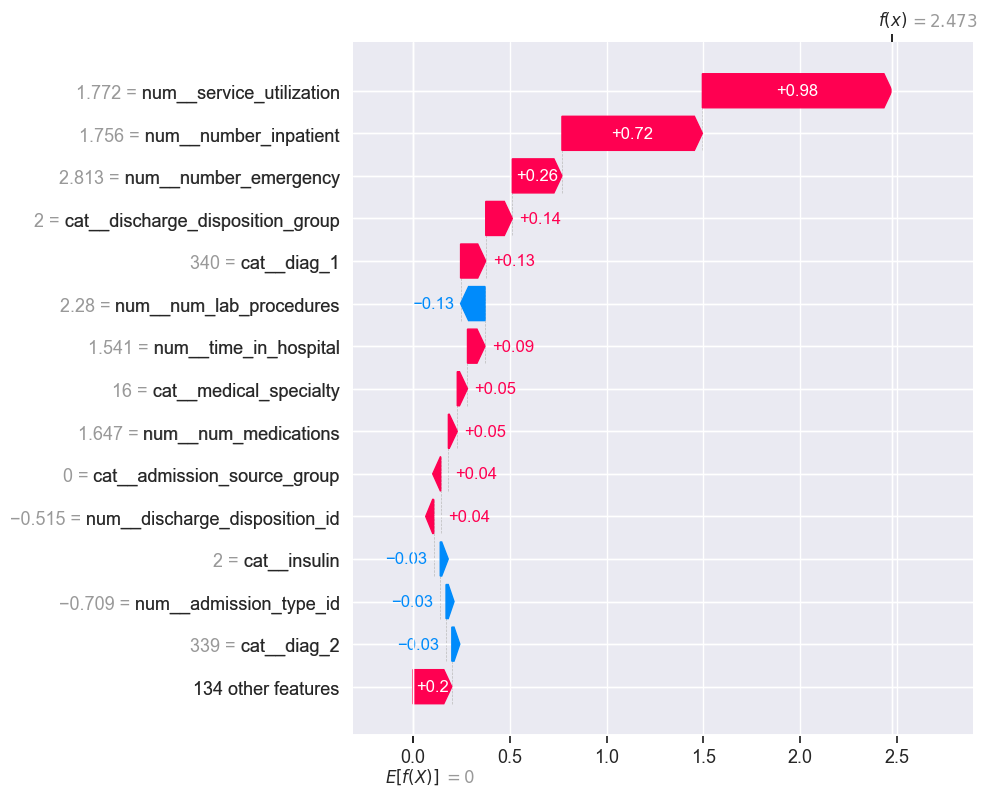


Misclassified Case (Index 3213)
True: 0, Pred: 1, Prob: 0.919


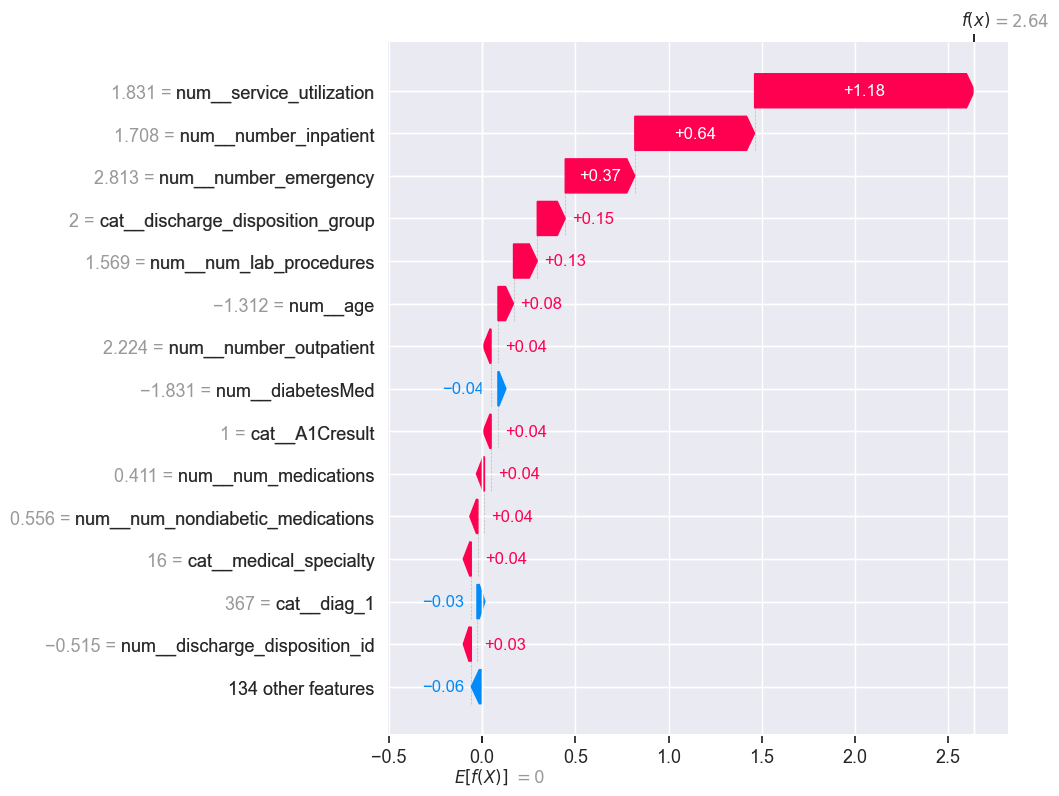

In [14]:
# Choose the best model for waterfall examples (LightGBM)
best_model = lgbm_metrics  # or models[3]
model_name = best_model["model_version"]

# Get SHAP data
shap_values = best_model["shap_values"]
shap_data = best_model["shap_data"]
feature_names = shap_data["feature_names"]
X_test_processed = shap_data["X_test_processed"]

# Get predictions and probabilities - convert to numpy arrays
y_true = best_model["y_test"].values 
y_pred = best_model["y_test_pred"]
y_prob = best_model["y_test_pred_proba"]

# Find interesting cases
correct_preds = y_true == y_pred
high_confidence = (y_prob > 0.9) #| (y_prob < 0.2)  # Very confident predictions

# Case 1: Well-classified, high confidence
well_classified_idx = np.where(correct_preds & high_confidence)[0]
if len(well_classified_idx) > 0:
    case1_idx = well_classified_idx[0]  # Pick first one
    print(f"Well-classified case: Index {case1_idx}")
    print(f"True: {y_true[case1_idx]}, Pred: {y_pred[case1_idx]}, Prob: {y_prob[case1_idx]:.3f}")

    # For LightGBM, we need to handle the nested array structure
    if isinstance(shap_values, list):
        shap_vals = shap_values[0][case1_idx]  # LightGBM returns list of arrays
    else:
        shap_vals = shap_values[case1_idx]

    explanation1 = shap.Explanation(
        values=shap_vals,
        base_values=0,  # Use 0 as base or calculate the actual base
        data=X_test_processed[case1_idx],
        feature_names=feature_names,
    )
    shap.plots.waterfall(explanation1, max_display=15, show=True)

# Case 2: Misclassified, high confidence (confident but wrong)
misclassified_idx = np.where(~correct_preds & high_confidence)[0]
if len(misclassified_idx) > 0:
    case2_idx = misclassified_idx[0]  # Pick first one
    print(f"\nMisclassified Case (Index {case2_idx})")
    print(f"True: {y_true[case2_idx]}, Pred: {y_pred[case2_idx]}, Prob: {y_prob[case2_idx]:.3f}")

    # For LightGBM, we need to handle the nested array structure
    if isinstance(shap_values, list):
        shap_vals = shap_values[0][case2_idx]  # LightGBM returns list of arrays
    else:
        shap_vals = shap_values[case2_idx]

    explanation2 = shap.Explanation(
        values=shap_vals,
        base_values=0,  # Use 0 as base or calculate the actual base
        data=X_test_processed[case2_idx],
        feature_names=feature_names,
    )
    shap.plots.waterfall(explanation2, max_display=15, show=True)

### Discussion

These case-level explanations offer a window into how models synthesize multiple features to reach a decision. 

When comparing well-classified and misclassified patients, the SHAP plots reveal remarkably similar decision patterns. This suggests the model applies its learned logic consistently, even when it misfires. In these cases, the errors may stem from ambiguous or borderline patient profiles, or reflect limits in the available features rather than erratic model behavior. 

For example, weight/BMI is a known strong correlator to diabetes, especially type 2. This dataset was severely limited by very high missing data in its weight feature (~97% missing), and this was removed. It seems likely that weight would have had significant predictive power. In other datasets related to diabetes, such as the Pima Indian Diabetes Dataset*, others have found that BMI is a top 3 predictor**. 

To better surface meaningful differences, future iterations could focus on high-confidence wrong predictions, which are more likely to expose flawed reasoning or unexpected interactions. This would help distinguish between “acceptable” errors and those that warrant further model refinement.
***
<sub>*https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
**https://www.kaggle.com/code/parulpandey/intrepreting-machine-learning-models?scriptVersionId=31158102&cellId=25</sub>

# 3. Model Agreement & Error Patterns

Even when models perform similarly on aggregate metrics, they may not make the same predictions - or the same mistakes. In this section, we explore how often models agree on patient-level predictions, and where their errors diverge. By examining prediction overlap, disagreement patterns, and types of misclassifications, we gain insight into each model’s decision boundaries, confidence, and failure modes.

This helps answer: *Do the models see risk the same way? And when they disagree — who’s right?*

## Model prediction agreement matrix

The heatmap below shows the pairwise agreement rates between the four machine learning models. Each value represents the percentage of test cases where both models made the same binary prediction at their optimized thresholds.

This comparison reveals how similarly these models behave in practice, beyond their performance metrics. High agreement suggests shared decision boundaries or reliance on similar features, while lower agreement points to divergent model logic — which may be valuable in identifying edge cases or for constructing ensembles.

As the logistic regression techniques worked off our bifurcated data set (see notebook p02), the number of predictions was different from the four machine learning models, so they were removed from this section.

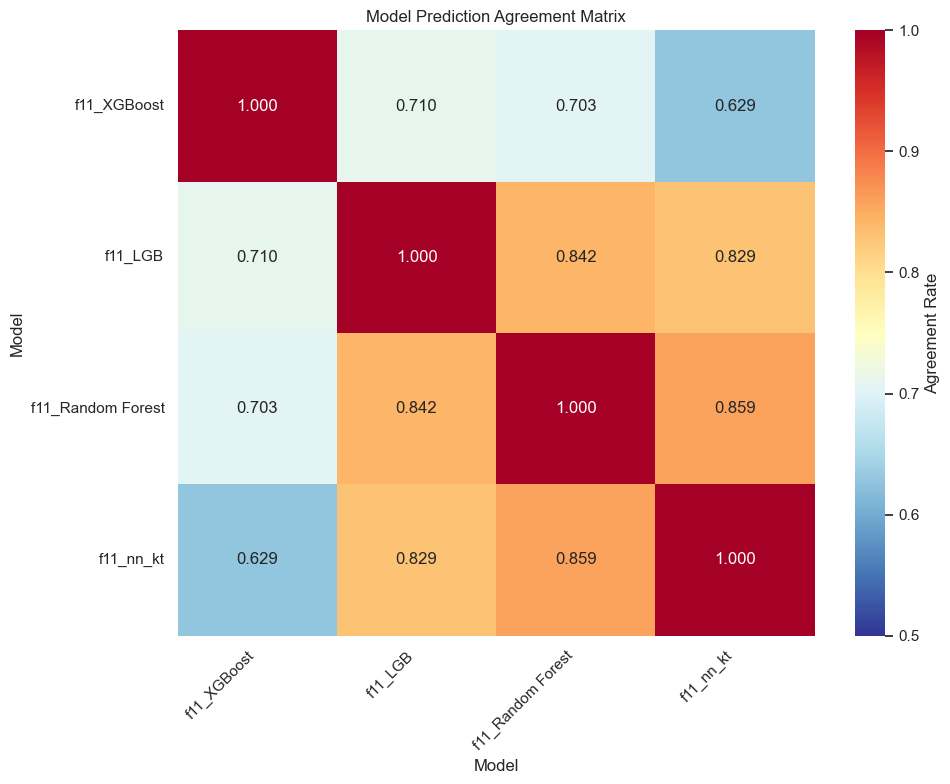

In [15]:
# First, let's check the sizes of the remaining models
models_subset = [model for model in models if 'log_' not in model['model_version']]

# Find the smallest common size
min_size = min(len(model['y_test_pred']) for model in models_subset)

# Create prediction agreement matrix using common subset
model_names = [model['model_version'] for model in models_subset]
n_models = len(models_subset)

# Create agreement matrix
agreement_matrix = np.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(n_models):
        if i == j:
            agreement_matrix[i, j] = 1.0  # Perfect agreement with itself
        else:
            # Use first min_size predictions for fair comparison
            pred_i = models_subset[i]['y_test_pred'][:min_size]
            pred_j = models_subset[j]['y_test_pred'][:min_size]
            agreement = np.mean(pred_i == pred_j)
            agreement_matrix[i, j] = agreement

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix,
            annot=True,
            fmt='.3f',
            cmap='RdYlBu_r',
            xticklabels=model_names,
            yticklabels=model_names,
            vmin=0.5,
            vmax=1.0,
            cbar_kws={'label': 'Agreement Rate'})

plt.title(f'Model Prediction Agreement Matrix')
plt.xlabel('Model')
plt.ylabel('Model')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Discussion

1. **Random Forest and the neural net agree most**: With 85.9% agreement, these two models are the most behaviorally aligned. Despite different architectures, they seem to converge on similar predictions, suggesting shared emphasis on recent utilization and encounter history.

2. **XGBoost is the behavioral outlier**: XGBoost shows the lowest agreement with every other model, especially the neural net (62.9%). Its predictions likely reflect a more selective or asymmetric decision boundary, shaped by its unique threshold and regularization profile.

3. **LightGBM plays the middle**: LGB aligns well with both Random Forest and the neural net (≥82%), suggesting its decision patterns balance between boosted trees and more general classifiers. This makes it a natural candidate for serving as a baseline comparator, or as the central model in a consensus or ensemble framework.

## Error analysis

Understanding how models fail is just as important as how they succeed. In this section, we explore where, how, and why misclassifications happen, both at the feature level and across error types.

We first compare SHAP-derived feature importance for correct vs incorrect predictions, then dig deeper into distributional differences in top features between correctly and incorrectly predicted patients. Finally, we examine the balance of false positives and false negatives, highlighting how some models (e.g. XGBoost) tend to over-call, while others (e.g. the neural net) are more conservative. These patterns offer practical insight into model risk profiles and suitability for deployment in settings with asymmetric costs.

### Feature Importance

The plots below compare the average SHAP values of the top features for correctly classified vs misclassified test cases, across all models ('Correct' in blue meaning all four models predicted that case correctly; 'All-wrong' meaning all four got that case wrong). This analysis helps us understand whether the same features are driving predictions across both correct and incorrect cases, and whether model logic changes depending on the outcome.

By observing these shifts, we can spot potential fragile dependencies, overreliance on noisy inputs, or differences in how confident the model is when it gets things right vs wrong.

In [16]:
error_models = [
    xgb_metrics,
    lgbm_metrics,
    rf_metrics,
    nn_metrics,
]

pred_df = pd.DataFrame(
    {
        "all_models_pred": sum(
            model["optimized_y_test_pred"] for model in error_models
        ),
        "y_test": error_models[0]["y_test"],
    }
)

pred_df["all_wrong"] = (
    (pred_df["all_models_pred"] == 4) & (pred_df["y_test"] == 0)
) | ((pred_df["all_models_pred"] == 0) & (pred_df["y_test"] == 1))

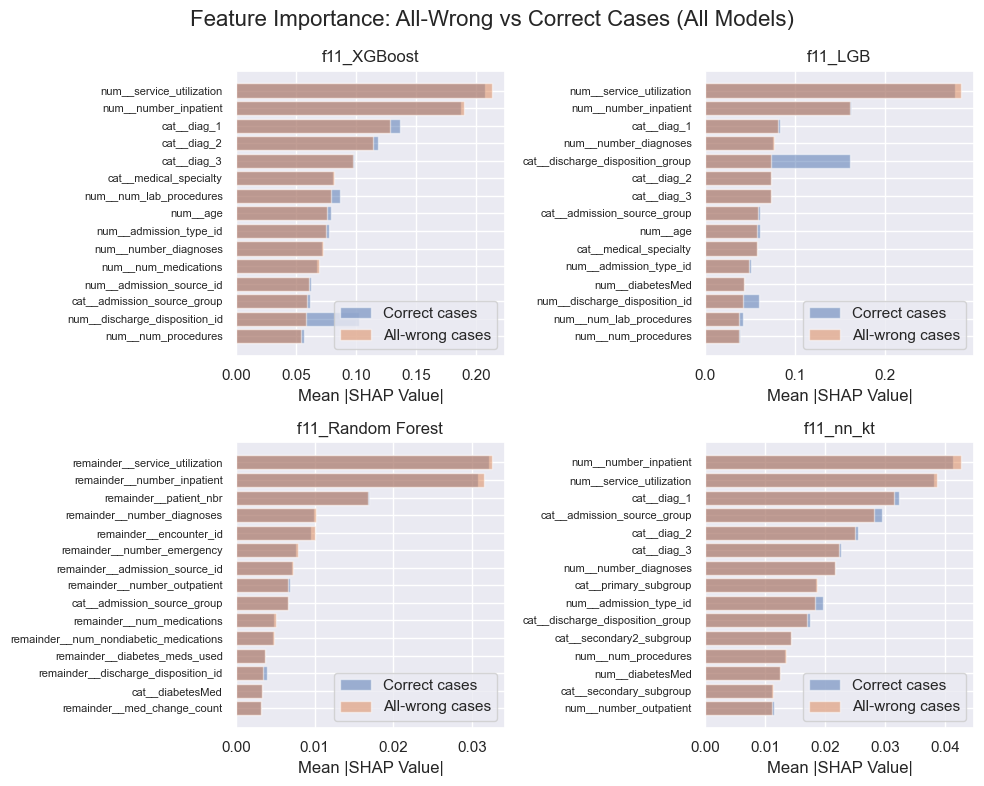

In [17]:
# Get indices of all-wrong cases
wrong_indices = pred_df[pred_df['all_wrong']].index.tolist()
correct_indices = pred_df[~pred_df['all_wrong']].index.tolist()

# Create subplots for all four models
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, model in enumerate(error_models):
    ax = axes[i]

    # Get SHAP data for this model
    shap_values = model['shap_values']
    feature_names = model['shap_data']['feature_names']

    # Handle different SHAP value shapes
    if isinstance(shap_values, list):
        # LightGBM returns list of arrays
        shap_vals = shap_values[0]
    elif len(shap_values.shape) == 3:
        # Neural network: (samples, features, 1) -> (samples, features)
        shap_vals = shap_values[:, :, 0]
    else:
        # Other models: (samples, features)
        shap_vals = shap_values

    # Filter indices to only include valid ones for this model
    max_idx = shap_vals.shape[0] - 1
    valid_wrong_indices = [idx for idx in wrong_indices if idx <= max_idx]
    valid_correct_indices = [idx for idx in correct_indices if idx <= max_idx]

    # Compare SHAP values for all-wrong vs correct cases
    if len(valid_wrong_indices) > 0:
        wrong_shap = shap_vals[valid_wrong_indices]
        correct_shap = shap_vals[valid_correct_indices]

        # Calculate mean absolute SHAP values
        wrong_mean = np.abs(wrong_shap).mean(0)
        correct_mean = np.abs(correct_shap).mean(0)

        # Top 15 features
        top_features = np.argsort(wrong_mean)[-15:]

        # Plot
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, correct_mean[top_features], alpha=0.5, label='Correct cases')
        ax.barh(y_pos, wrong_mean[top_features], alpha=0.5, label='All-wrong cases')
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature_names[i] for i in top_features], fontsize=8)
        ax.set_xlabel('Mean |SHAP Value|')
        ax.set_title(f'{model["model_version"]}')
        ax.legend()

plt.suptitle('Feature Importance: All-Wrong vs Correct Cases (All Models)', fontsize=16)
plt.tight_layout()
plt.show()

### Discussion

1. **Core features are stable across correct and incorrect cases**: Features like num__service_utilization and num__number_inpatient consistently have the highest SHAP values regardless of classification accuracy. This suggests that models apply the same core logic across most predictions, and that misclassifications may result from subtle thresholds or interactions, not shifts in primary reasoning.

2. **Certain categorical features are more prominent in model mistakes**: In both XGBoost and LightGBM, the feature cat__discharge_disposition_id shows a notable increase in SHAP contribution for misclassified cases compared to correct ones. This suggests these models may overweight specific discharge codes in ambiguous cases, possibly leading to errors when category signals are misleading or rare. In contrast, Random Forest and the neural net show little variation between correct and incorrect predictions, indicating a more stable use of features, even when they’re wrong.

3. **Neural net shows nearly identical SHAP profiles across all predictions**: The NN’s bar heights for correct vs incorrect cases are virtually indistinguishable — suggesting it applies its logic consistently, regardless of whether it’s right or wrong. This consistency might be beneficial for explainability, but could also indicate limited adaptiveness to edge cases.

## Error Type Breakdown & Model Bias

This pair of plots breaks down model performance by error type, specifically false positives (FP) vs false negatives (FN). While accuracy and F1-score summarize overall correctness, this view reveals each model’s decision bias: are they more likely to over-call or under-call positive cases?

The left plot shows the absolute and relative counts of FP and FN errors. The right plot summarizes this with a FP/FN ratio:
- A ratio >1 means the model is more prone to false alarms (over-calling)
- A ratio <1 means it misses more true positives (under-calling)
- A ratio near 1 indicates balanced error behavior

In [18]:
# Error breakdown by true class (FN vs FP)
error_breakdown_data = []

for model in models:
    y_true = model['y_test'].values if hasattr(model['y_test'], 'values') else model['y_test']
    y_pred = model['y_test_pred']

    # Calculate error types
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()  # False Positives: predicted readmission, didn't happen
    fn = ((y_true == 1) & (y_pred == 0)).sum()  # False Negatives: missed actual readmissions

    total = len(y_true)
    total_errors = fp + fn

    error_breakdown_data.append({
        'Model': model['model_version'],
        'False Positives': fp,
        'FP Rate (%)': (fp / total) * 100,
        'False Negatives': fn,
        'FN Rate (%)': (fn / total) * 100,
        'Total Errors': total_errors,
        'Error Rate (%)': (total_errors / total) * 100,
        'FP/FN Ratio': fp / fn if fn > 0 else np.inf,
        'Bias': 'Over-calling' if fp > fn else 'Under-calling' if fn > fp else 'Balanced'})

error_df = pd.DataFrame(error_breakdown_data)

# Display the table
print("Error Breakdown by Type")
print("=" * 80)
print("False Positives: Predicted readmission, but didn't happen")
print("False Negatives: Missed actual readmissions")
print("=" * 80)
display_cols = ['Model', 'False Positives', 'FP Rate (%)', 'False Negatives', 'FN Rate (%)', 'FP/FN Ratio', 'Bias']
print(error_df[display_cols].round(2).to_string(index=False))

Error Breakdown by Type
False Positives: Predicted readmission, but didn't happen
False Negatives: Missed actual readmissions
            Model  False Positives  FP Rate (%)  False Negatives  FN Rate (%)  FP/FN Ratio          Bias
    f11_log_Lasso             2545        17.79             2832        19.80         0.90 Under-calling
     f11_log_ENet             2580        18.04             2806        19.62         0.92 Under-calling
      f11_XGBoost             6313        31.02             1635         8.03         3.86  Over-calling
          f11_LGB             2940        14.45             4087        20.08         0.72 Under-calling
f11_Random Forest             3522        17.30             3803        18.69         0.93 Under-calling
        f11_nn_kt             2832        13.91             4837        23.77         0.59 Under-calling


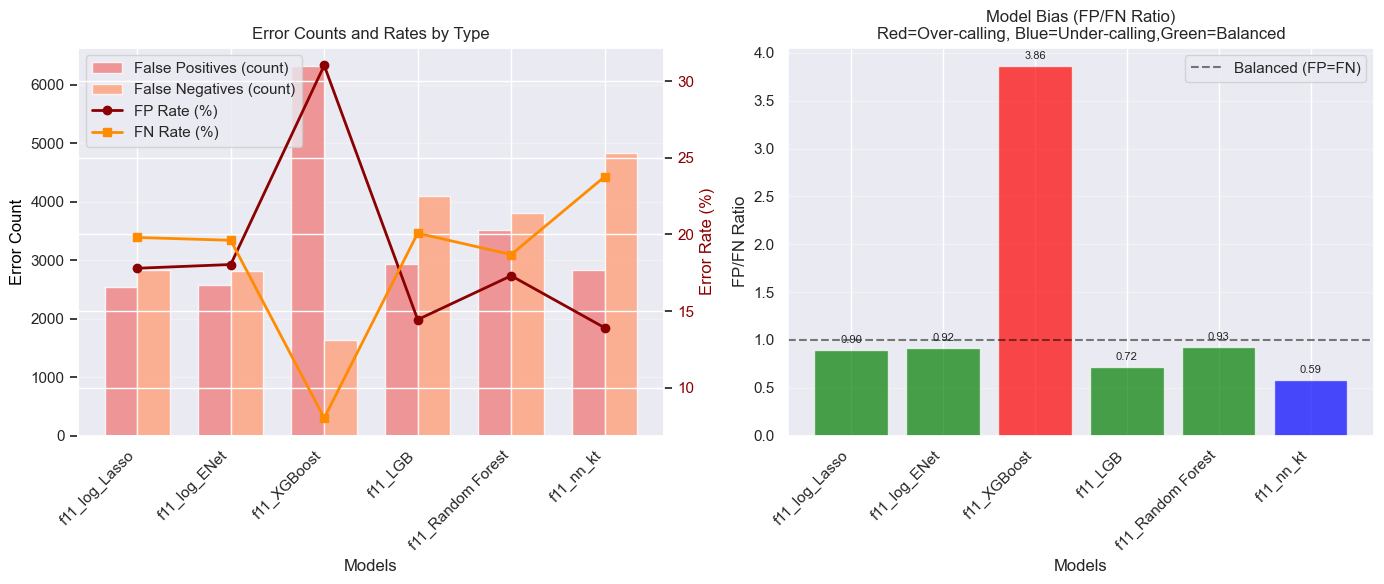

In [19]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Combined error counts and rates
ax1 = axes[0]
x = np.arange(len(error_df))
width = 0.35

# Plot counts
bars1 = ax1.bar(x - width/2, error_df['False Positives'], width, label='False Positives (count)', alpha=0.8, color='lightcoral')
bars2 = ax1.bar(x + width/2, error_df['False Negatives'], width, label='False Negatives (count)', alpha=0.8, color='lightsalmon')

ax1.set_xlabel('Models')
ax1.set_ylabel('Error Count', color='black')
ax1.set_title('Error Counts and Rates by Type')
ax1.set_xticks(x)
ax1.set_xticklabels(error_df['Model'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add secondary y-axis for rates
ax1_twin = ax1.twinx()
ax1_twin.plot(x, error_df['FP Rate (%)'], 'o-', color='darkred', linewidth=2,
markersize=6, label='FP Rate (%)')
ax1_twin.plot(x, error_df['FN Rate (%)'], 's-', color='darkorange', linewidth=2,
markersize=6, label='FN Rate (%)')
ax1_twin.set_ylabel('Error Rate (%)', color='darkred')
ax1_twin.tick_params(axis='y', labelcolor='darkred')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 2. FP/FN Ratio (bias indicator)
ax2 = axes[1]
colors = ['red' if ratio > 1.5 else 'blue' if ratio < 0.67 else 'green' for ratio in
error_df['FP/FN Ratio']]
bars = ax2.bar(x, error_df['FP/FN Ratio'], color=colors, alpha=0.7)

ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Balanced (FP=FN)')
ax2.set_xlabel('Models')
ax2.set_ylabel('FP/FN Ratio')
ax2.set_title('Model Bias (FP/FN Ratio)\nRed=Over-calling, Blue=Under-calling,Green=Balanced')
ax2.set_xticks(x)
ax2.set_xticklabels(error_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add ratio values on bars
for bar, ratio in zip(bars, error_df['FP/FN Ratio']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{ratio:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Discussion

1. **XGBoost heavily favors recall — at a cost**: XGBoost shows the highest false positive rate (30%) and an FP/FN ratio of 3.86, far beyond all other models. It is aggressively tuned to capture positives, but does so by generating a high number of false alarms — a tradeoff that may only be appropriate in high-stakes, high-recall settings.

2. **Neural network is the most conservative model**: The Keras-tuned NN has the lowest FP/FN ratio (0.59), indicating a bias toward under-calling positive cases. It minimizes false positives but at the cost of a high false negative count, which may be problematic when missing true positives is risky.

## Feature Distributions: Correct vs Incorrect Predictions

To explore how specific features relate to model success or failure, the plots below compare the distribution of feature values for correctly classified vs misclassified test cases in the LightGBM model's case. These density plots help identify whether errors are concentrated in certain value ranges, potentially exposing ambiguous regions, overlap between classes, or poor model calibration.

This level of analysis is particularly useful when interpreting why models fail, especially when SHAP values look similar across outcomes.

In [20]:
# Feature distributions for misclassified vs correctly classified
# Using the best model (LightGBM) from error_models
best_model = lgbm_metrics

# Get predictions and features
y_true = best_model['y_test'].values if hasattr(best_model['y_test'], 'values') else best_model['y_test']
y_pred = best_model['y_test_pred']
y_prob = best_model['y_test_pred_proba']

# Get feature data
X_processed = best_model['shap_data']['X_test_processed']
feature_names = best_model['shap_data']['feature_names']

# Create prediction categories
tp_mask = (y_true == 1) & (y_pred == 1)  # True Positives
tn_mask = (y_true == 0) & (y_pred == 0)  # True Negatives  
fp_mask = (y_true == 0) & (y_pred == 1)  # False Positives
fn_mask = (y_true == 1) & (y_pred == 0)  # False Negatives

correct_mask = tp_mask | tn_mask
incorrect_mask = fp_mask | fn_mask

# Use predefined top features
top_features = [
    "num__num_lab_procedures",
    "num__number_diagnoses",
    "num__number_inpatient",
    "num__service_utilization",
]

# Create analysis DataFrame
analysis_data = []
for i in range(len(y_true)):
    category = 'True Positive' if tp_mask[i] else \
            'True Negative' if tn_mask[i] else \
            'False Positive' if fp_mask[i] else 'False Negative'

    correct = 'Correct' if correct_mask[i] else 'Incorrect'

    row = {
        'Category': category,
        'Correct': correct,
        'Prediction_Prob': y_prob[i]
    }

    # Add top features by name
    for feature_name in top_features:
        feat_idx = list(feature_names).index(feature_name)
        row[feature_name] = X_processed[i, feat_idx]

    analysis_data.append(row)

feat_dist_df = pd.DataFrame(analysis_data)

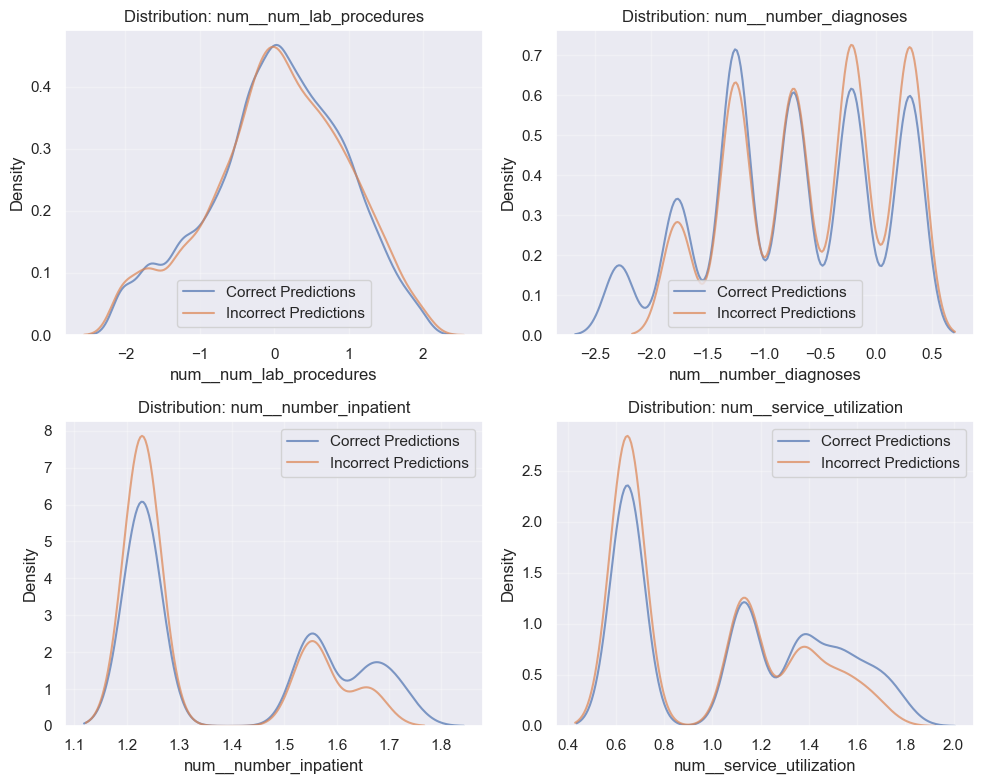

In [21]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

top_features = [
    "num__num_lab_procedures",
    "num__number_diagnoses",
    "num__number_inpatient",
    "num__service_utilization",
]

for i, feature_name in enumerate(top_features):  # Now iterating over column names
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # KDE plot for correct vs incorrect
    correct_data = feat_dist_df[feat_dist_df["Correct"] == "Correct"][feature_name]
    incorrect_data = feat_dist_df[feat_dist_df["Correct"] == "Incorrect"][feature_name]

    # Remove any infinite or very large values for plotting
    correct_clean = correct_data[
        (correct_data > np.percentile(correct_data, 1))
        & (correct_data < np.percentile(correct_data, 99))
    ]
    incorrect_clean = incorrect_data[
        (incorrect_data > np.percentile(incorrect_data, 1))
        & (incorrect_data < np.percentile(incorrect_data, 99))
    ]

    # Plot KDE
    if len(correct_clean) > 10 and len(incorrect_clean) > 10:
        sns.kdeplot(data=correct_clean, ax=ax, label="Correct Predictions", alpha=0.7)
        sns.kdeplot(
            data=incorrect_clean, ax=ax, label="Incorrect Predictions", alpha=0.7
        )
    else:
        # Fallback to histogram if not enough data for KDE
        ax.hist(
            correct_clean, alpha=0.7, label="Correct Predictions", density=True, bins=20
        )
        ax.hist(
            incorrect_clean,
            alpha=0.7,
            label="Incorrect Predictions",
            density=True,
            bins=20,
        )

    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution: {feature_name}")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Despite being top predictors, features like num__number_diagnoses and num__lab_procedures show near-identical distributions for correct vs incorrect predictions. This may indicate that while these features are important, they aren’t always decisive on their own — the model may rely on interactions or thresholds that aren’t well-resolved.

## SHAP value residual plot

This plot shows how LightGBM prediction error rate varies across SHAP sum bins, where SHAP sum represents the total model-attributed risk for each prediction. In essence, it tells us: **at what risk levels does the model struggle most to be correct?**

Each bin represents a range of SHAP sums, and the y-axis shows the proportion of misclassified cases in that bin. The red dashed line marks the overall average error rate for reference.

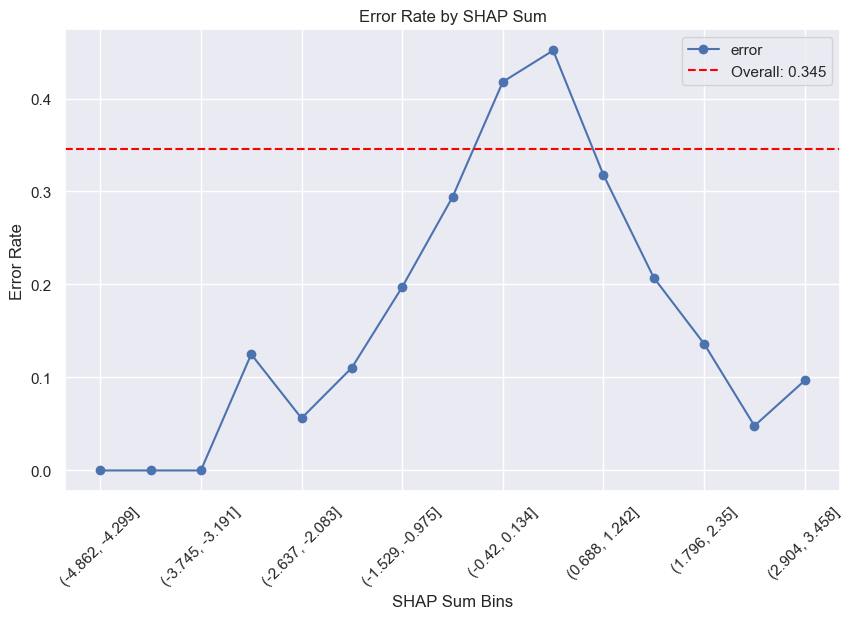

In [22]:
# Binned SHAP residual plot
best_model = lgbm_metrics

# Get data
y_true = best_model['y_test'].values if hasattr(best_model['y_test'], 'values') else best_model['y_test']
y_pred = best_model['y_test_pred']
shap_values = best_model['shap_values'][0] if isinstance(best_model['shap_values'], list) else best_model['shap_values']

# Calculate SHAP sum and errors
shap_sum = shap_values.sum(axis=1)
errors = (y_true != y_pred).astype(int)

# Bin and calculate error rates
df = pd.DataFrame({'shap_sum': shap_sum, 'error': errors})
df['bin'] = pd.cut(df['shap_sum'], bins=15)
error_rates = df.groupby('bin')['error'].mean()

# Plot
plt.figure(figsize=(10, 6))
error_rates.plot(kind='line', marker='o')
plt.axhline(y=errors.mean(), color='red', linestyle='--', label=f'Overall: {errors.mean():.3f}')
plt.xlabel('SHAP Sum Bins')
plt.ylabel('Error Rate')
plt.title('Error Rate by SHAP Sum')
plt.legend()
plt.xticks(rotation=45)
plt.show()

1. **Error rate peaks around the decision boundary**: The highest error rates occur in bins where the SHAP sum is near zero — i.e., where the model is least certain about classification. This suggests that borderline-risk patients are indeed the hardest to classify correctly.

2. **Model confidence correlates well with correctness**: The smooth U-shape of the curve shows that SHAP sum is a good proxy for model certainty: errors drop off as SHAP magnitude increases in either direction.

# 4. Practical Considerations

While model performance and interpretability are essential, they aren’t the only factors that matter in real-world applications. This section focuses on the practical aspects of deploying each model, including resource demands, complexity tradeoffs, and operational fit.

We examine training time, inference speed, and model size to understand resource efficiency. Then we explore the tradeoff between predictive performance and interpretability, helping identify when a simpler model may be more appropriate. Finally, we summarize each model’s deployment readiness in terms of ease of use, maintainability, and expected clinical impact.

## Training time / inference speed / model size table

While predictive performance often dominates model selection, practical deployment depends on far more than just metrics. This table compares each model on key operational criteria - including training time, model size, and hyperparameter complexity - to assess how feasible each is for real-world use. We also assign a qualitative deployment readiness rating based on factors like speed, interpretability, and infrastructure demands.

In short, models like LightGBM and Lasso strike the best balance between performance and practicality, making them strong candidates not just in the lab, but in the real world.

Model Training & Deployment Characteristics
***
| Model           | Training Time  | Hyperparameter Method | Trials  | Model Size | Operational Fit |
|-----------------|----------------|-----------------------|---------|------------|------------------|
| Logistic Lasso  | 17m 33s        | Optuna                |  15     | 47 KB      | Excellent        |
| Elastic Net     | >60m (stopped) | Optuna                |   7     | 47 KB      | Slow Training    |
| XGBoost         | 7m             | Optuna                | 400     | 3.8 MB     | Good             |
| LightGBM        | 10m            | Optuna                | 200     | 1.9 MB     | Excellent        |
| Random Forest   | 34m            | Optuna                | 200     | 6.3 MB     | Moderate         |
| Neural Network  | 34m            | KerasTuner            | Unknown | 1.2 GB     | Poor             |

### Model Complexity Tradeoff

The tradeoffs between interpretability and performance have been written on at length by many commenters; some, like Rudin (2019), argue that we should avoid black-box models entirely and favor inherently interpretable approaches. While we agree that interpretability is critical,  post hoc explainability (e.g., SHAP) can offer valuable insight even for more complex models like gradient boosting — without a significant loss in transparency.

In practice, this means that models like LightGBM or XGBoost, when paired with tools like SHAP, may offer a strong middle ground: high performance and actionable explanations, particularly when decisions are reviewed in context.
***
<sub>Rudin, C. (2019). Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead. Nature Machine Intelligence, 1(5), 206–215. https://doi.org/10.1038/s42256-019-0048-x</sub>

# 5. Recommendations & Reflections

Across all evaluation dimensions - performance, interpretability, calibration, and deployment readiness - LightGBM emerges as the most well-rounded model. It consistently ranks near the top in model metrics, while maintaining modest training time, a small model size, and compatibility with SHAP explanations for transparency. This makes it a strong candidate for real-world use, especially in settings where both predictive power and accountability matter.

If interpretability were the top priority — for example, in a setting requiring transparent audit trails or frontline clinical acceptance — Logistic Lasso would be the preferred model. While it underperforms the tree-based models in absolute terms, it’s simple, consistent, and easily explainable. 

The key tradeoff throughout this project has been performance vs interpretability, with model complexity and inference cost as secondary considerations. More complex models like XGBoost and neural networks offered strong raw performance, but at the cost of interpretability, calibration stability, and deployment burden. Post hoc explanations (e.g., SHAP) helped bridge the gap, but didn’t fully offset those limitations.

If more time or domain expertise were available, next steps would include:
<!-- - Fairness and subgroup analysis: How do these models perform across age groups, comorbidities, or socio-demographic segments?
- Cost-benefit modeling: Quantifying the impact of false positives vs false negatives in clinical or operational terms.
- Feature refinement: Consulting with clinical experts to refine or engineer better predictors, especially around discharge planning and care coordination signals. -->

Ultimately, the choice of model depends on the deployment context, but from a balanced perspective, LightGBM offers the strongest overall case for adoption.

n.b. - The original study that this dataset comes from used a strange model selection criteria that was, in this author's opinion, engineered in a way to support claims of signifiance for a particular diagnostic predictor. I actually tried to and could not reproduce their selection methodology; I may or may not publish that notebook at a later date. However, while I am not a clinician and cannot appreciate the importance of HbA1C measurements from a medical standpoint, it is also readily apparent that this dataset left a lot to be desired - lack of information on patient weight, for example.